# Census Income Project

This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.

The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian non-institutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

1. A single cell estimate of the population 16+ for each state.

2. Controls for Hispanic Origin by age and sex.

3. Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.

# Loading libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt               #for plotting and EDA
import seaborn as sns                         #for plotting and EDA
from sklearn.linear_model import LogisticRegression             #classification model
from sklearn.naive_bayes import GaussianNB                      #classification model
from sklearn.tree import DecisionTreeClassifier                 #classification model
from sklearn.ensemble import RandomForestClassifier             #classification model
from sklearn.svm import SVC                                     #classification model
from sklearn.model_selection import train_test_split            #for splitting dataset into training and testing
from sklearn.metrics import accuracy_score                      #for checking model accuracy
from sklearn.metrics import roc_auc_score                       #for checking model accuracy
from sklearn.metrics import confusion_matrix, classification_report      #for checking model accuracy
from sklearn.model_selection import cross_val_score                      #for cross validating model
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Census dataset')
df = pd.DataFrame(data = df)

In [3]:
df.head(10)

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
5,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
6,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
7,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
8,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K
9,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,>50K


Education_num seems to be the numeric code for Education, for instance Bachelors is 13, HS-grad is 9 and so on.

In [4]:
df.shape

(32560, 15)

In [5]:
df.dtypes

Age                int64
Workclass         object
Fnlwgt             int64
Education         object
Education_num      int64
Marital_status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_gain       int64
Capital_loss       int64
Hours_per_week     int64
Native_country    object
Income            object
dtype: object

Workclass, Education, Marital_status, Occupation, Relationship, Race, Sex, Native_country are all categorical in nature, as is the case with the target variable Income.

While Age, Fnlwgt, Education_num, Capital_gain, Capital_loss, Hours_per_week are continuous in nature.

In [6]:
df.apply(lambda x: len(x.unique()))

Age                  73
Workclass             9
Fnlwgt            21647
Education            16
Education_num        16
Marital_status        7
Occupation           15
Relationship          6
Race                  5
Sex                   2
Capital_gain        119
Capital_loss         92
Hours_per_week       94
Native_country       42
Income                2
dtype: int64

In [7]:
df.describe()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Mean age is 38 and mode is 37, the age range is 17 - 90 while IQR is 28 - 48.

Education number is just encoded data for education, most of the people have max education level of some college.

For both capital gain and capital loss we can see that most of the data is around 0.

For hours per week most of the data is centered towards 40 hours per week.

# Checking and treating missing values

In [8]:
df.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

No null values in the dataset.

# EDA and Data Visualisation

In [9]:
s = (df.dtypes == 'object')
cate_cols = list(s[s].index)

print("Categorical variables:")
print(cate_cols)

Categorical variables:
['Workclass', 'Education', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native_country', 'Income']


In [10]:
s = (df.dtypes == 'int64')
cont_cols = list(s[s].index)

print("Continuous variables:")
print(cont_cols)

Continuous variables:
['Age', 'Fnlwgt', 'Education_num', 'Capital_gain', 'Capital_loss', 'Hours_per_week']


In [11]:
cont_cols.remove('Education_num')

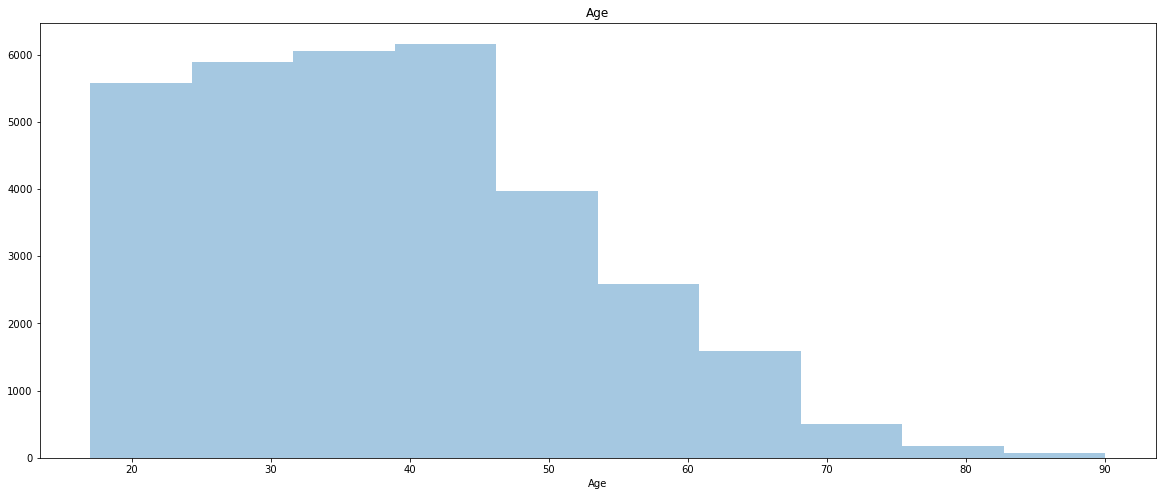

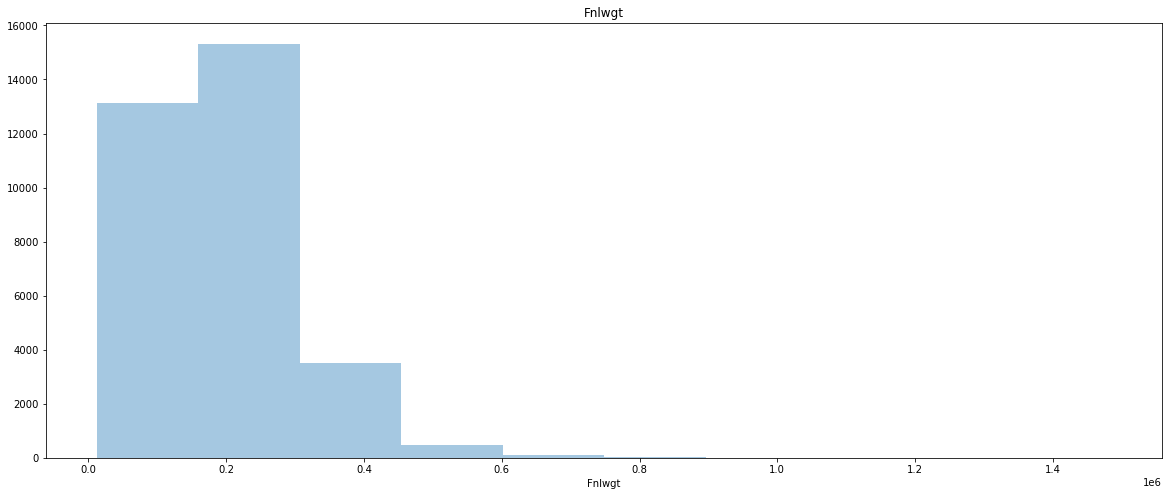

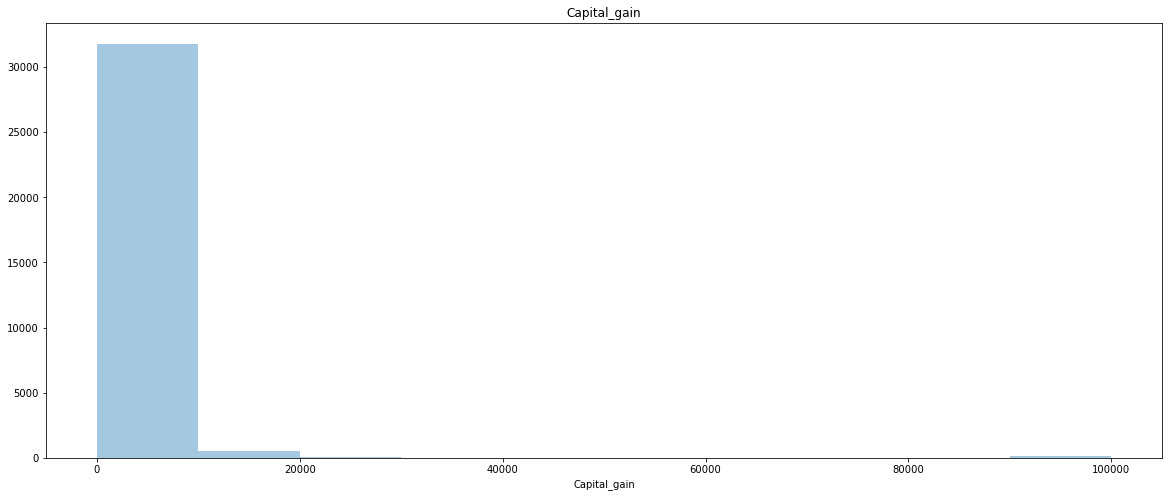

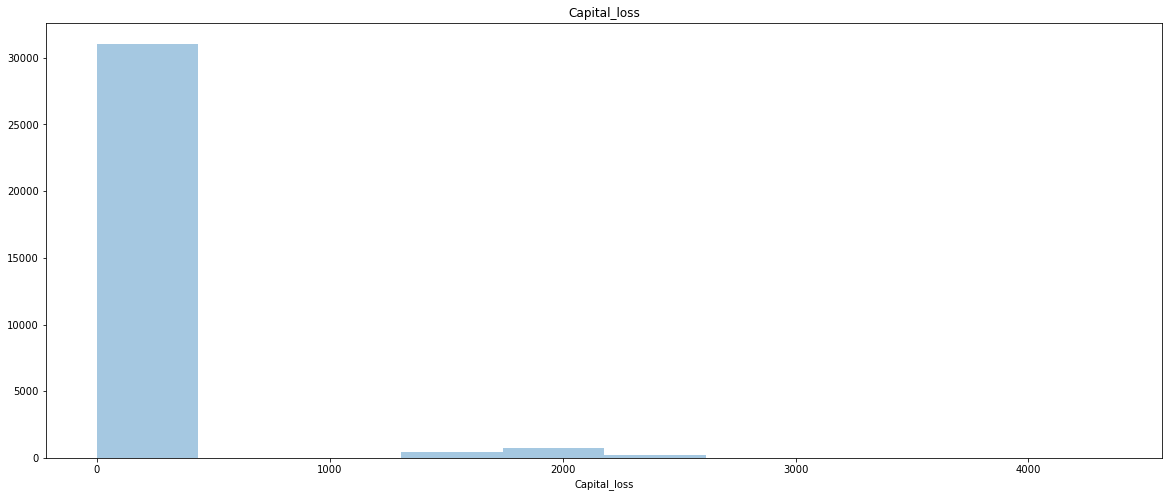

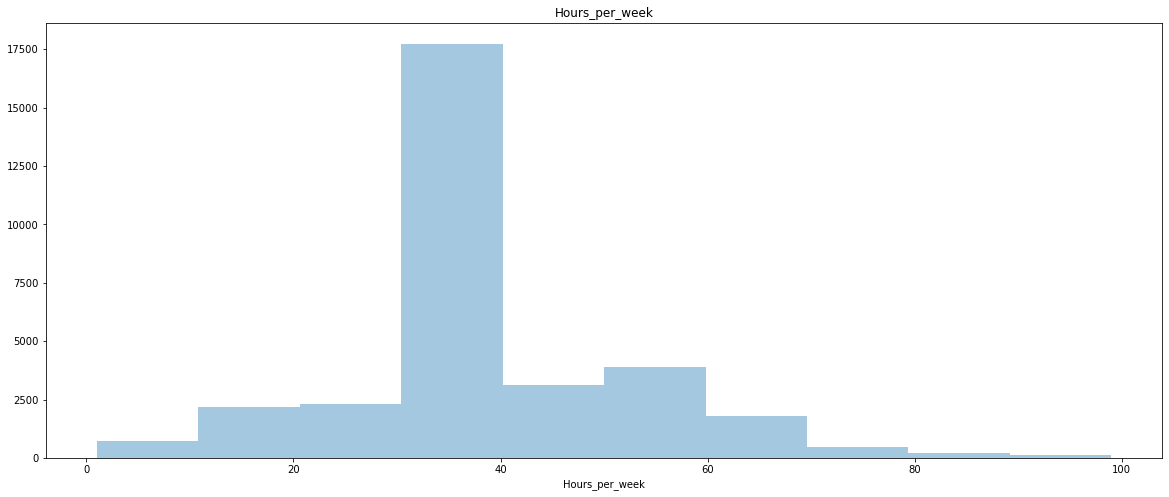

In [12]:
for i in cont_cols:                                 #univariate analysis
    plt.figure(figsize = (20, 8))
    sns.distplot(a= df[i], bins = 10, kde= False)
    plt.title(i)
    plt.show()

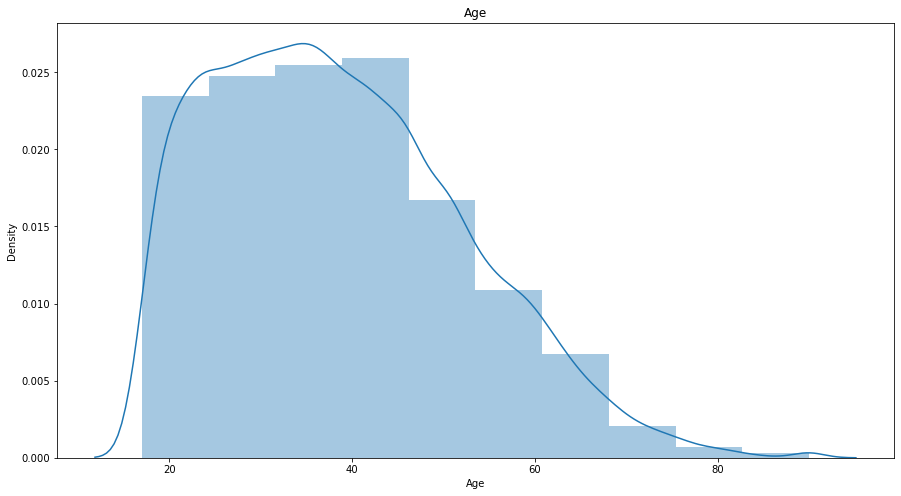

In [13]:
plt.figure(figsize = (15, 8))
sns.distplot(df['Age'], bins = 10)
plt.title('Age')
plt.show()

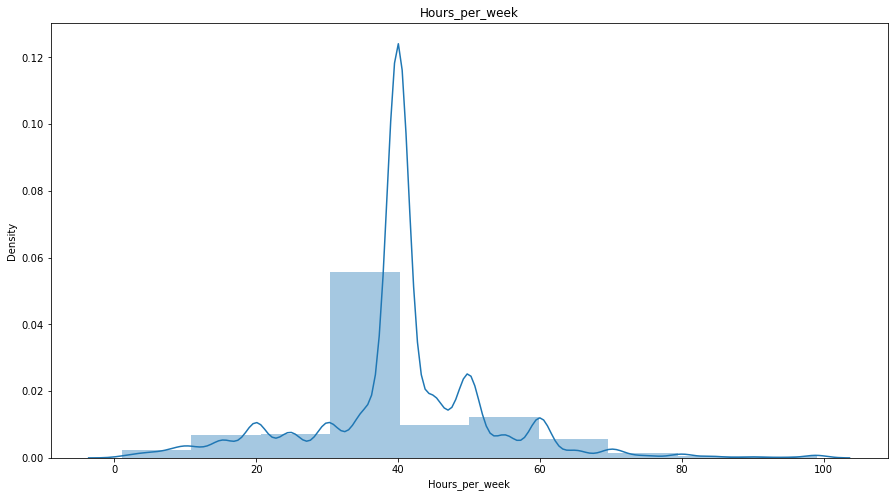

In [14]:
plt.figure(figsize = (15, 8))
sns.distplot(df['Hours_per_week'], bins = 10)
plt.title('Hours_per_week')
plt.show()

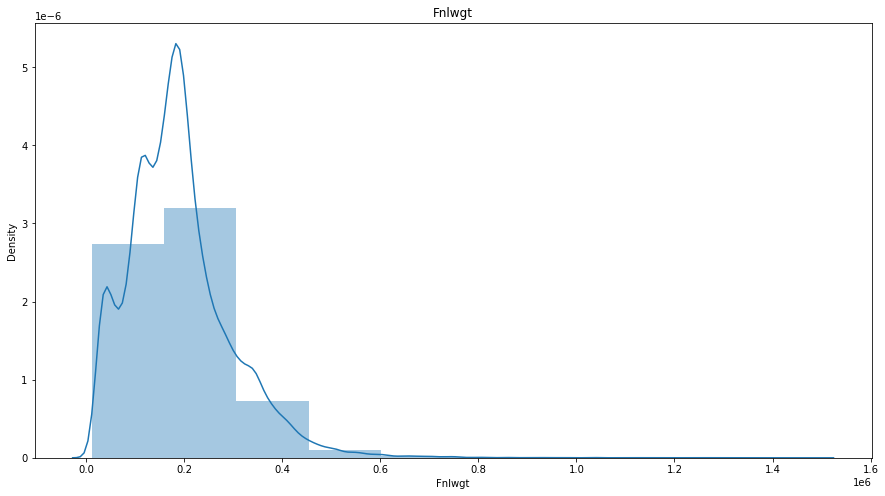

In [15]:
plt.figure(figsize = (15, 8))
sns.distplot(df['Fnlwgt'], bins = 10)
plt.title('Fnlwgt')
plt.show()

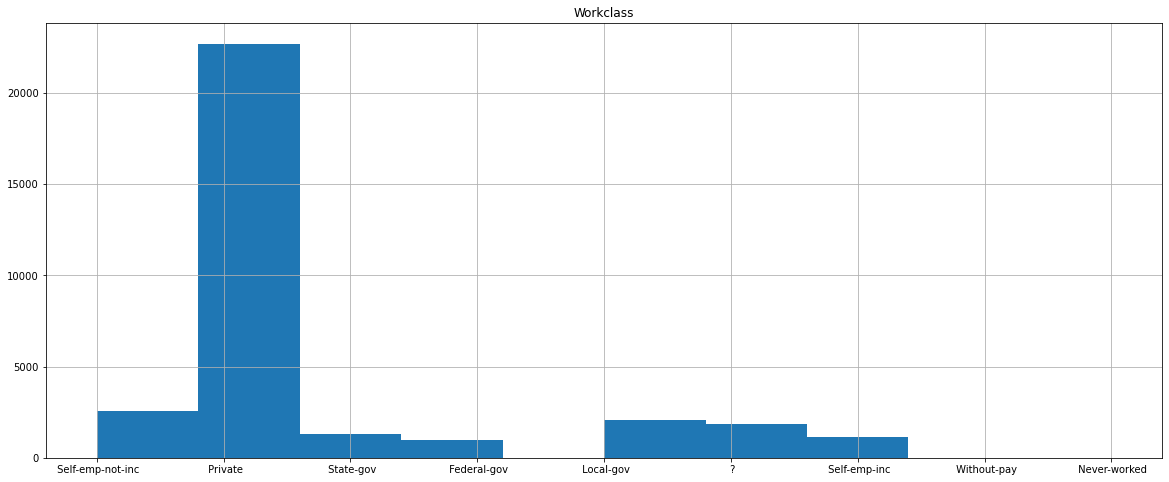

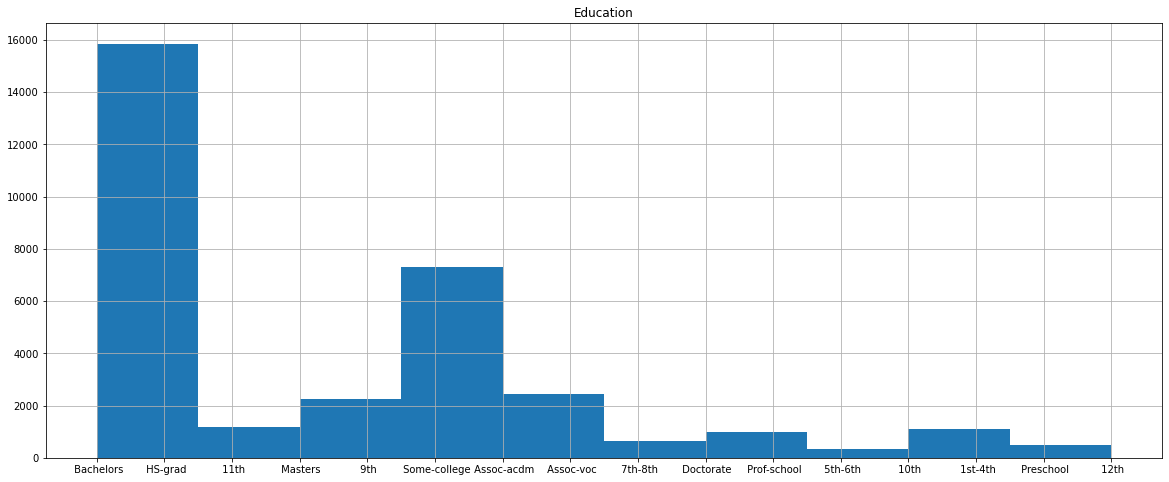

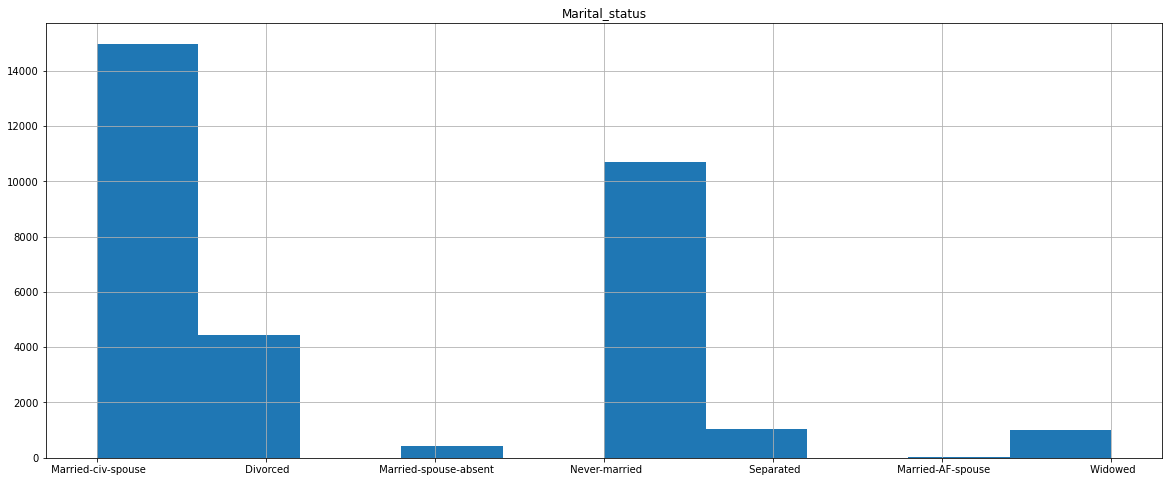

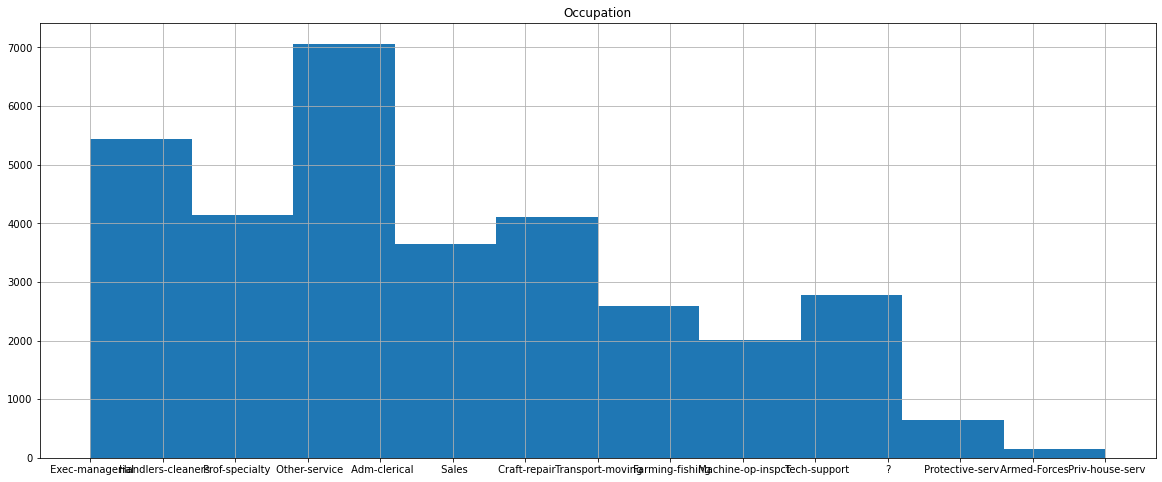

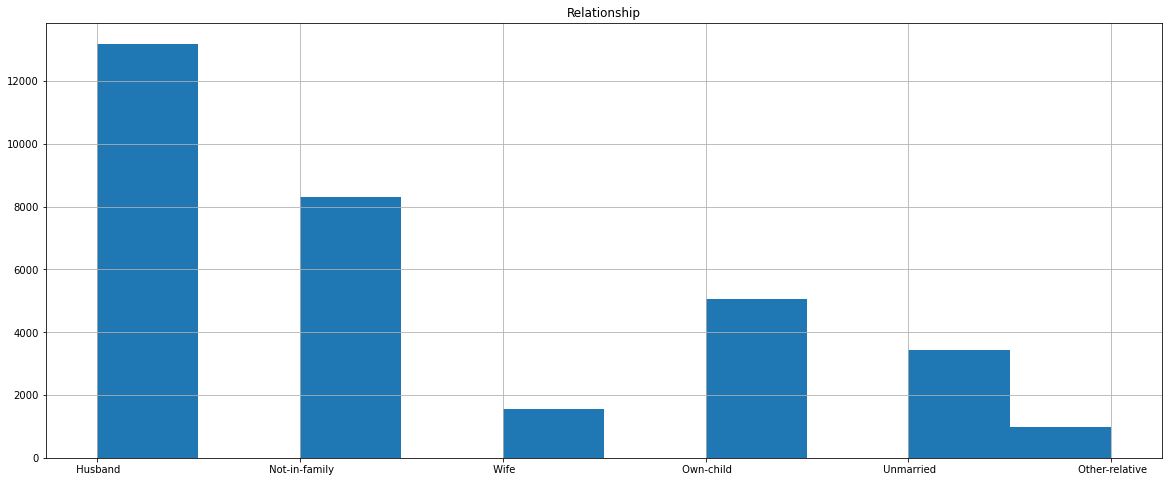

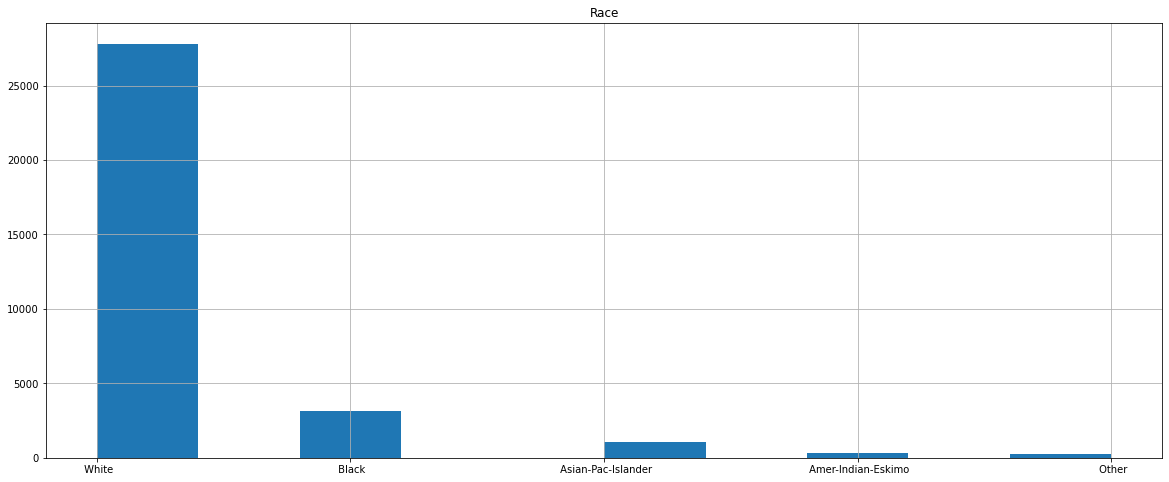

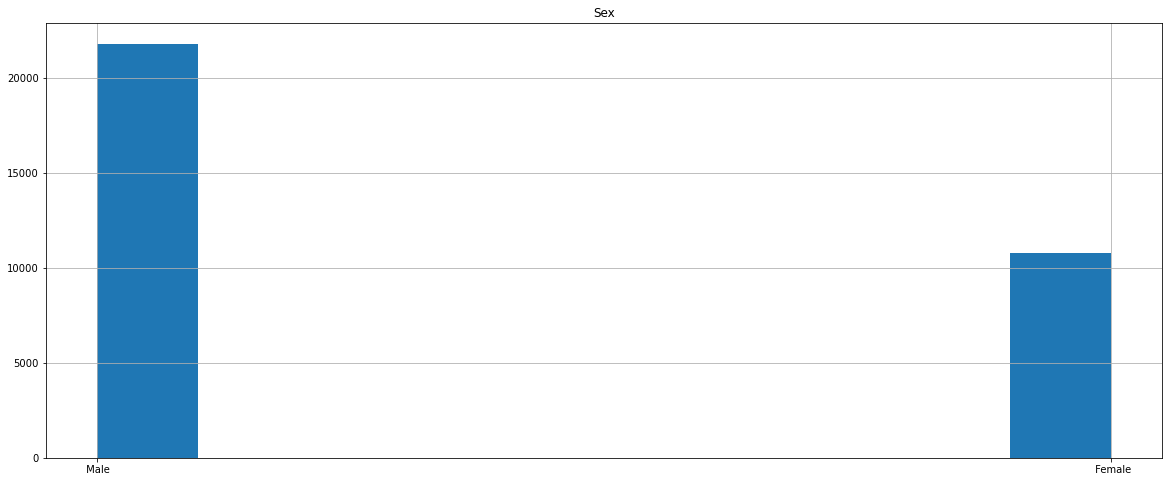

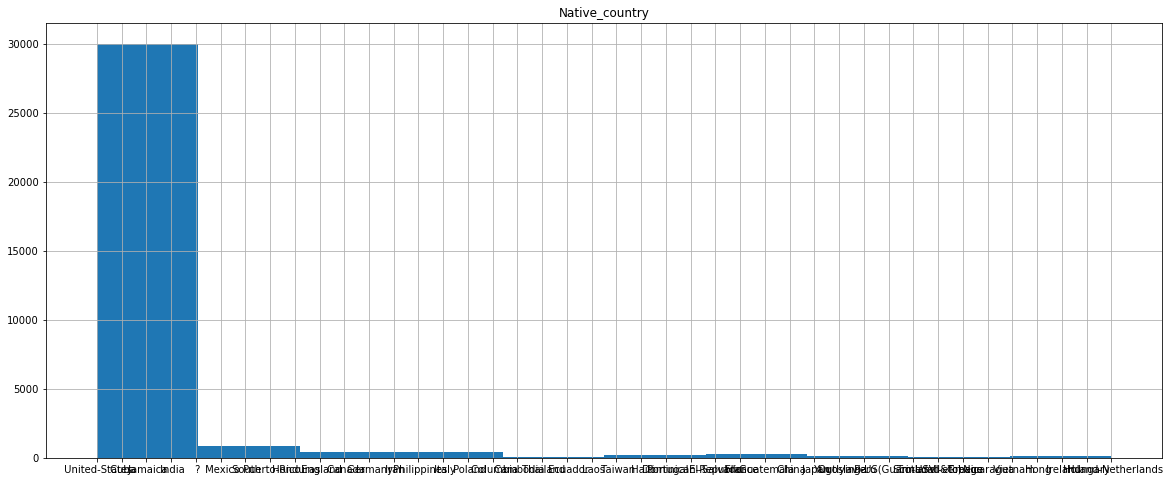

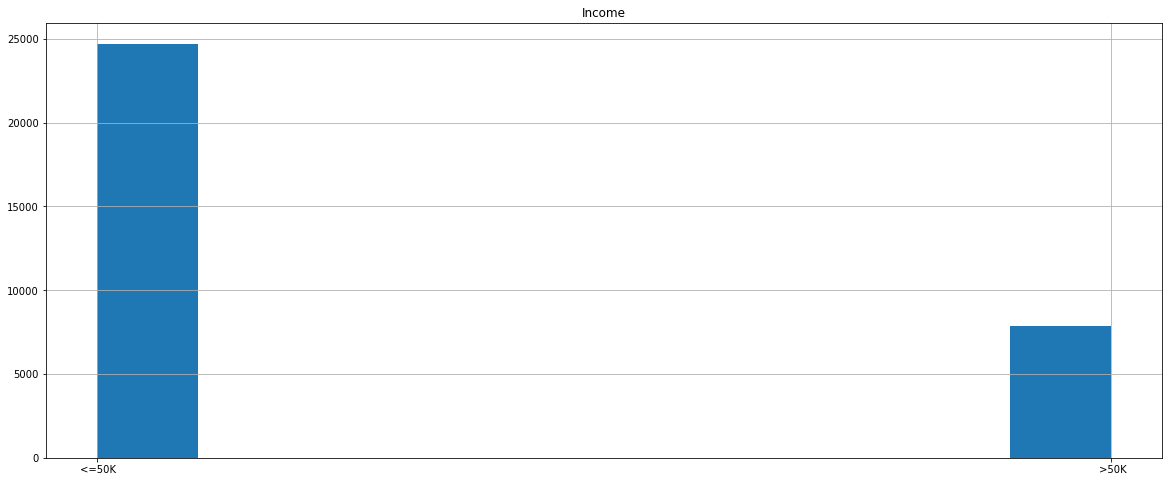

In [16]:
for i in cate_cols:                                 #univariate analysis
    plt.figure(figsize = (20, 8))
    df[i].hist(grid = True)
    plt.title(i)
    plt.show()

In [17]:
df.loc[df['Occupation'] == ' ?']

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
26,54,?,180211,Some-college,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
60,32,?,293936,7th-8th,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,<=50K
68,25,?,200681,Some-college,10,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
76,67,?,212759,10th,6,Married-civ-spouse,?,Husband,White,Male,0,0,2,United-States,<=50K
105,17,?,304873,10th,6,Never-married,?,Own-child,White,Female,34095,0,32,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32529,35,?,320084,Bachelors,13,Married-civ-spouse,?,Wife,White,Female,0,0,55,United-States,>50K
32530,30,?,33811,Bachelors,13,Never-married,?,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,<=50K
32538,71,?,287372,Doctorate,16,Married-civ-spouse,?,Husband,White,Male,0,0,10,United-States,>50K
32540,41,?,202822,HS-grad,9,Separated,?,Not-in-family,Black,Female,0,0,32,United-States,<=50K


In [18]:
df.loc[df['Workclass'] == ' ?']

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
26,54,?,180211,Some-college,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
60,32,?,293936,7th-8th,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,<=50K
68,25,?,200681,Some-college,10,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
76,67,?,212759,10th,6,Married-civ-spouse,?,Husband,White,Male,0,0,2,United-States,<=50K
105,17,?,304873,10th,6,Never-married,?,Own-child,White,Female,34095,0,32,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32529,35,?,320084,Bachelors,13,Married-civ-spouse,?,Wife,White,Female,0,0,55,United-States,>50K
32530,30,?,33811,Bachelors,13,Never-married,?,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,<=50K
32538,71,?,287372,Doctorate,16,Married-civ-spouse,?,Husband,White,Male,0,0,10,United-States,>50K
32540,41,?,202822,HS-grad,9,Separated,?,Not-in-family,Black,Female,0,0,32,United-States,<=50K


In [19]:
df.loc[(df['Workclass'] == ' ?') & (df['Occupation'] != ' ?')]

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income


In [20]:
df.loc[(df['Workclass'] != ' ?') & (df['Occupation'] == ' ?')]

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
5360,18,Never-worked,206359,10th,6,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
10844,23,Never-worked,188535,7th-8th,4,Divorced,?,Not-in-family,White,Male,0,0,35,United-States,<=50K
14771,17,Never-worked,237272,10th,6,Never-married,?,Own-child,White,Male,0,0,30,United-States,<=50K
20336,18,Never-worked,157131,11th,7,Never-married,?,Own-child,White,Female,0,0,10,United-States,<=50K
23231,20,Never-worked,462294,Some-college,10,Never-married,?,Own-child,Black,Male,0,0,40,United-States,<=50K
32303,30,Never-worked,176673,HS-grad,9,Married-civ-spouse,?,Wife,Black,Female,0,0,40,United-States,<=50K
32313,18,Never-worked,153663,Some-college,10,Never-married,?,Own-child,White,Male,0,0,4,United-States,<=50K


In [21]:
df.loc[(df['Workclass'] == ' ?') & (df['Occupation'] == ' ?')]

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
26,54,?,180211,Some-college,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
60,32,?,293936,7th-8th,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,<=50K
68,25,?,200681,Some-college,10,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
76,67,?,212759,10th,6,Married-civ-spouse,?,Husband,White,Male,0,0,2,United-States,<=50K
105,17,?,304873,10th,6,Never-married,?,Own-child,White,Female,34095,0,32,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32529,35,?,320084,Bachelors,13,Married-civ-spouse,?,Wife,White,Female,0,0,55,United-States,>50K
32530,30,?,33811,Bachelors,13,Never-married,?,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,<=50K
32538,71,?,287372,Doctorate,16,Married-civ-spouse,?,Husband,White,Male,0,0,10,United-States,>50K
32540,41,?,202822,HS-grad,9,Separated,?,Not-in-family,Black,Female,0,0,32,United-States,<=50K


All workclass columns with ' ?' as value have occupations as ' ?', no exceptions.

Occupations with ' ?' have either ' ?' or 'Never-worked' as workclass.

Text(0.5, 1.0, 'Income Pie Chart')

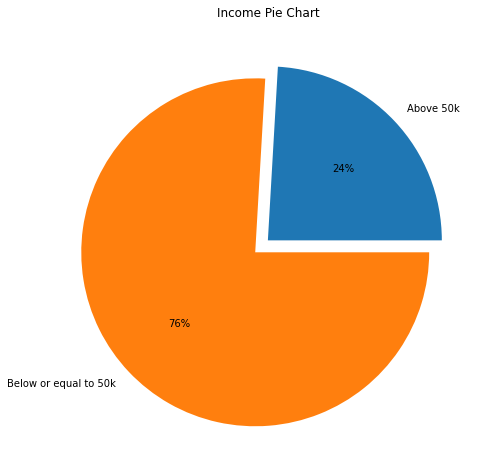

In [22]:
vals = [df['Income'][df['Income'] == ' >50K'].count() , df['Income'][df['Income'] == ' <=50K'].count()]
plt.figure(figsize = (15, 8))
label = ["Above 50k" , "Below or equal to 50k"]
plt.pie(vals , labels=label , autopct = '%1.0f%%' , explode=(0 , 0.1))
plt.title("Income Pie Chart")

76% of people in the given data set has income below or equal to 50k, while only 24% are earning above 50k.

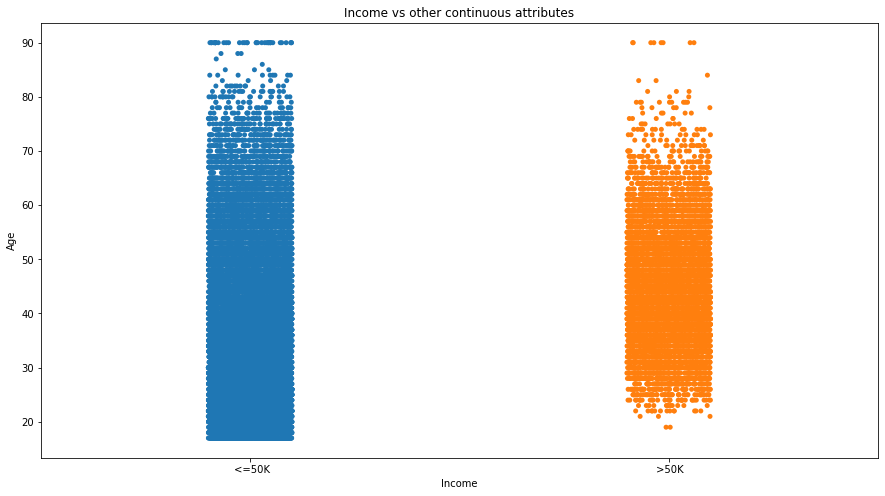

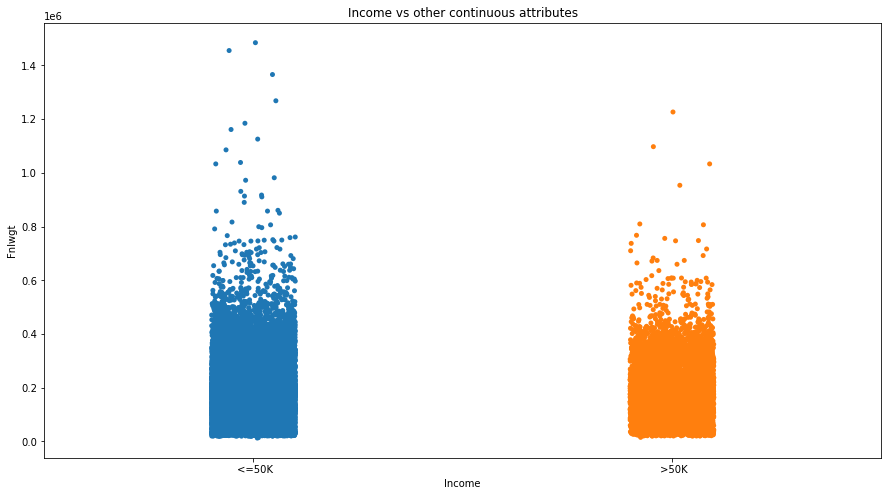

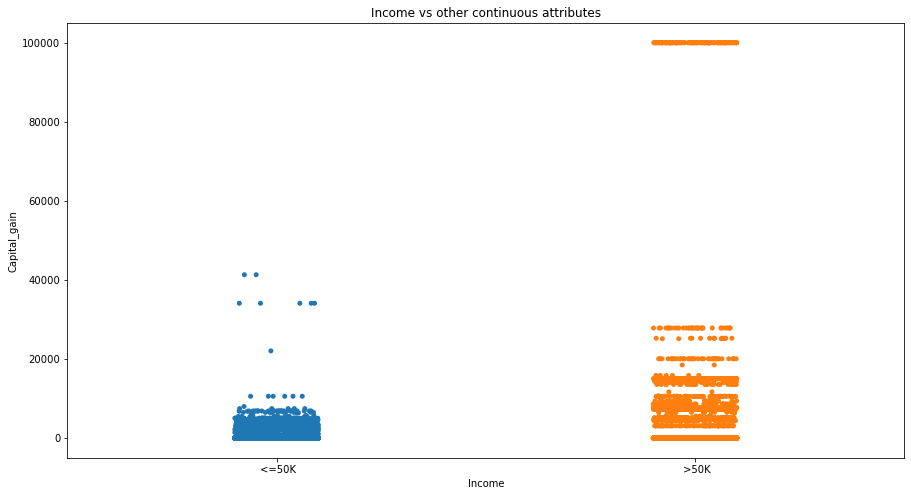

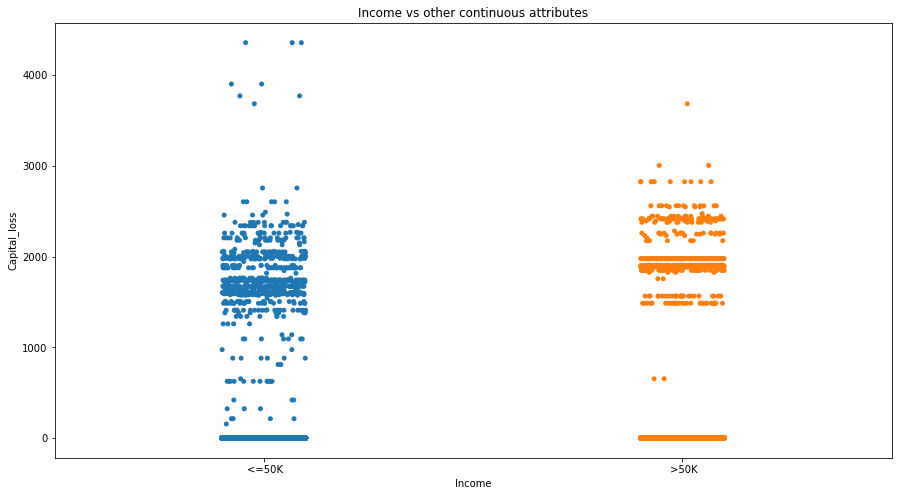

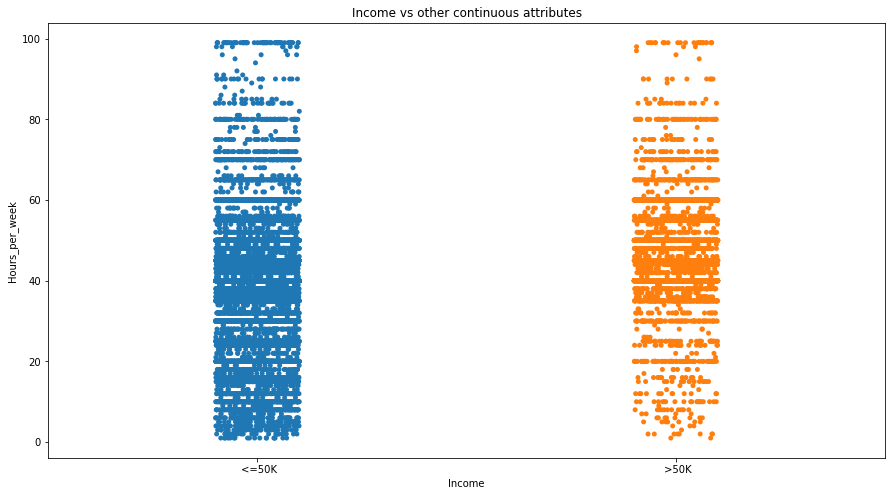

In [23]:
for i in cont_cols:                                          #bivariate analysis
    plt.figure(figsize = (15, 8))
    ax = sns.stripplot(df['Income'], df[i])
    ax.set(xlabel = 'Income', ylabel = i)
    plt.title('Income vs other continuous attributes')
    plt.show()

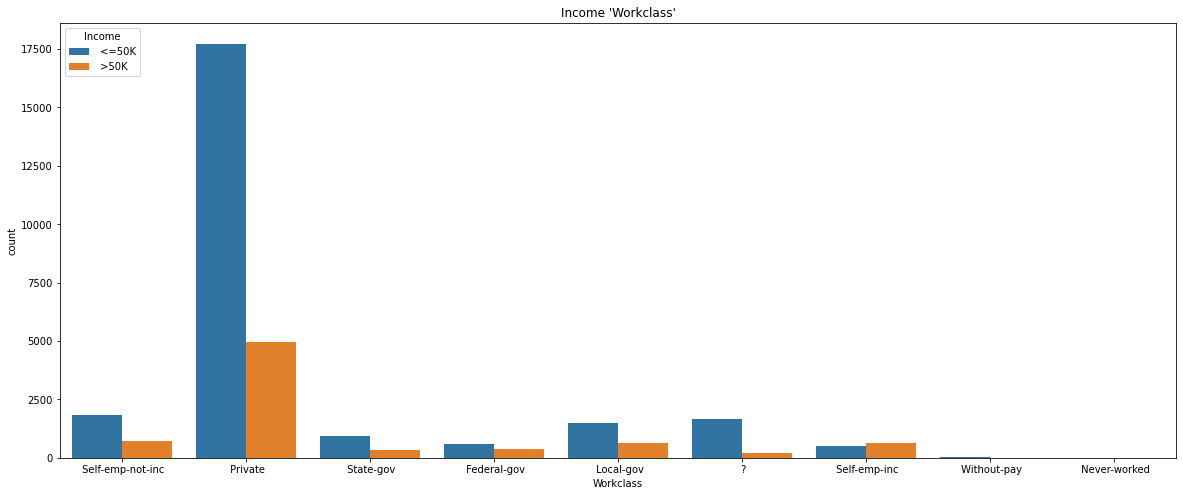

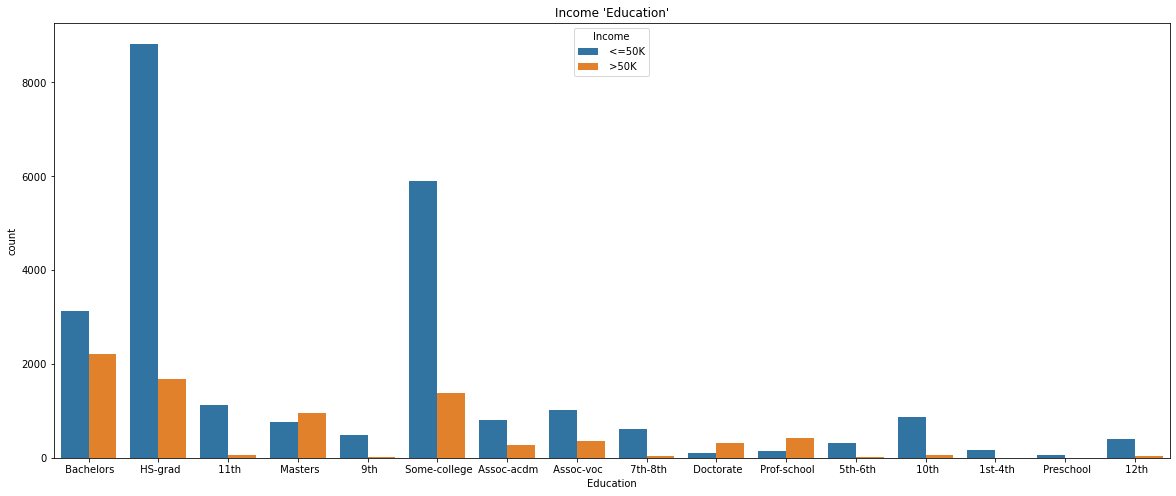

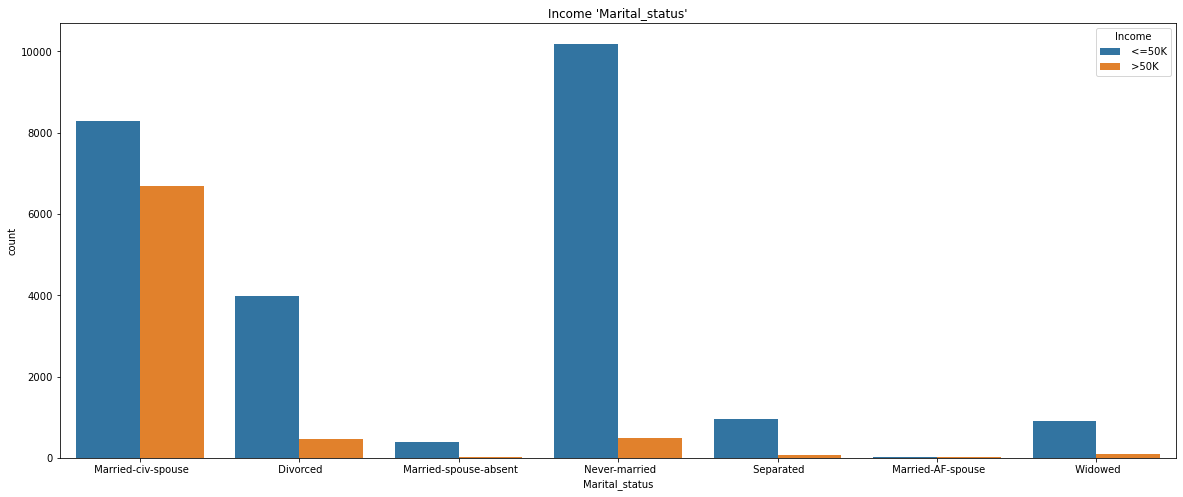

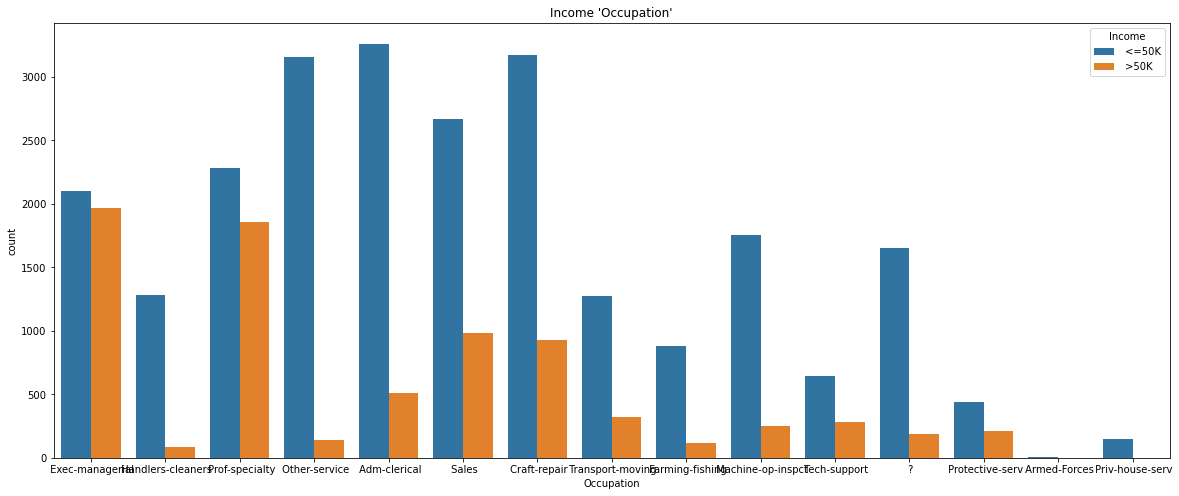

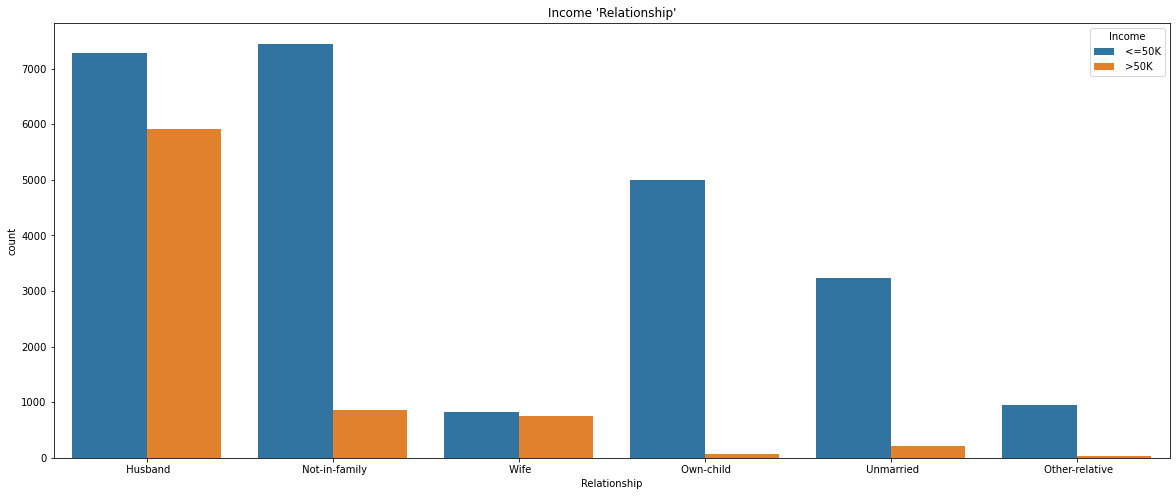

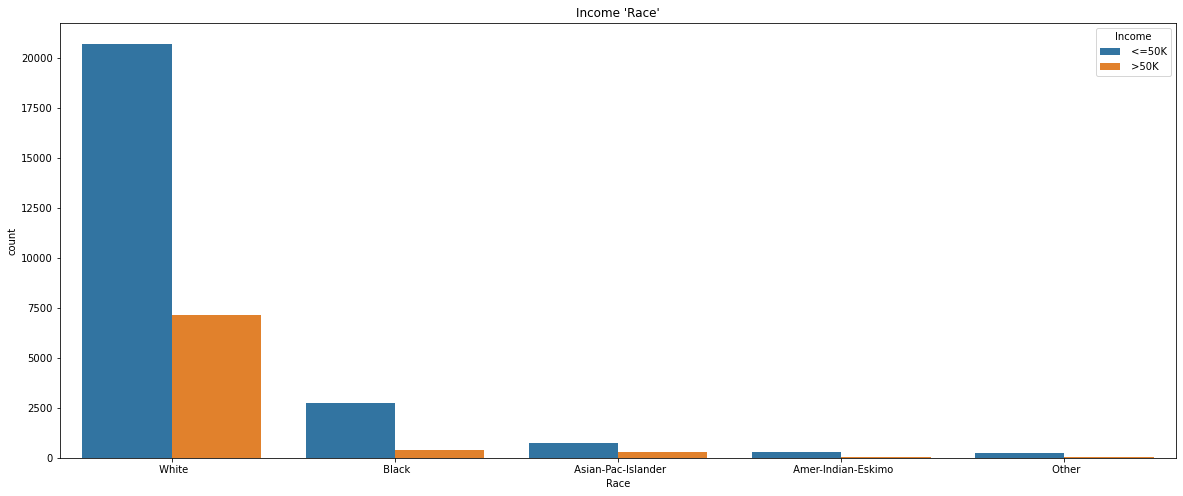

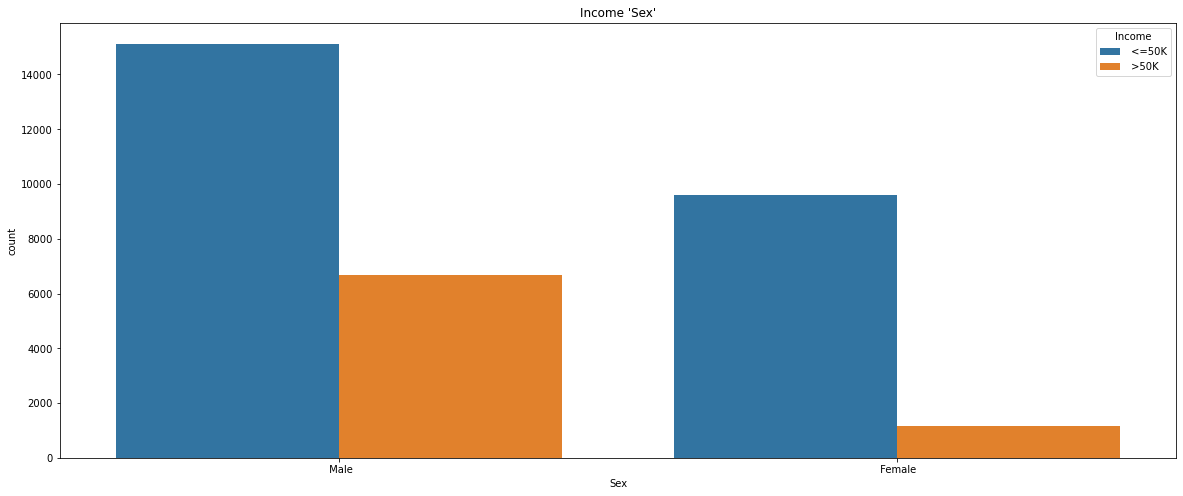

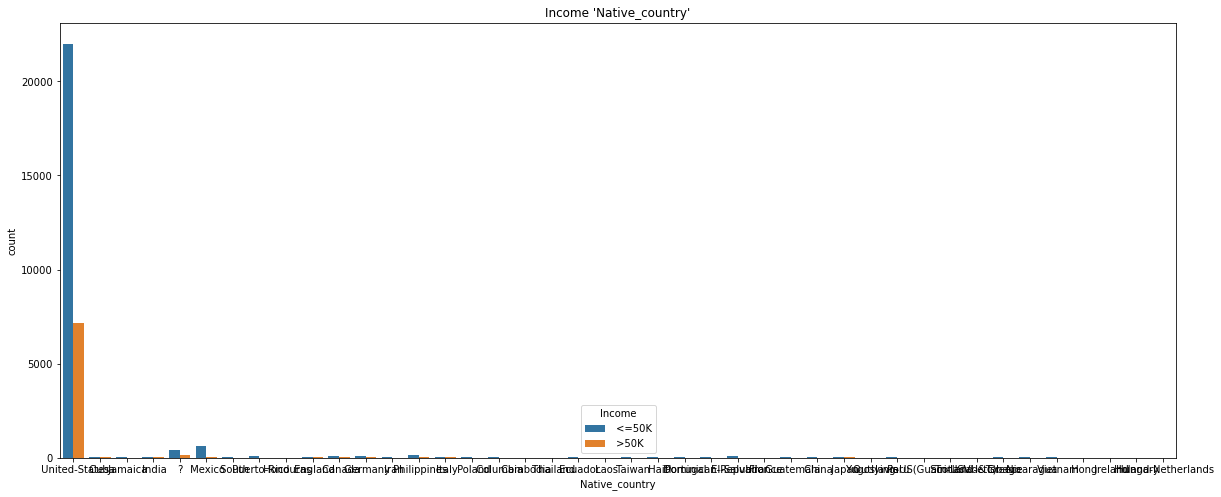

In [24]:
for i in cate_cols[:-1]:                                #bivariate analysis
    plt.figure(figsize=(20, 8))
    plt.title("Income '%s'"%i)
    sns.countplot(df[i],hue=df['Income'])

Self Employed people are the only ones in workclass column who seems to have more 50K+ earners and less <=50k earners.

While in education column, Masters, Doctorate and Prof-School are the only ones which have more 50k+ earners and less <=50k earners.

People who are married irrespective of Relationship (Husband or Wife) seems to have higher chance of earning over 50k.

In [25]:
df['Income'].replace(' <=50K', 0, inplace = True)
df['Income'].replace(' >50K', 1, inplace = True)

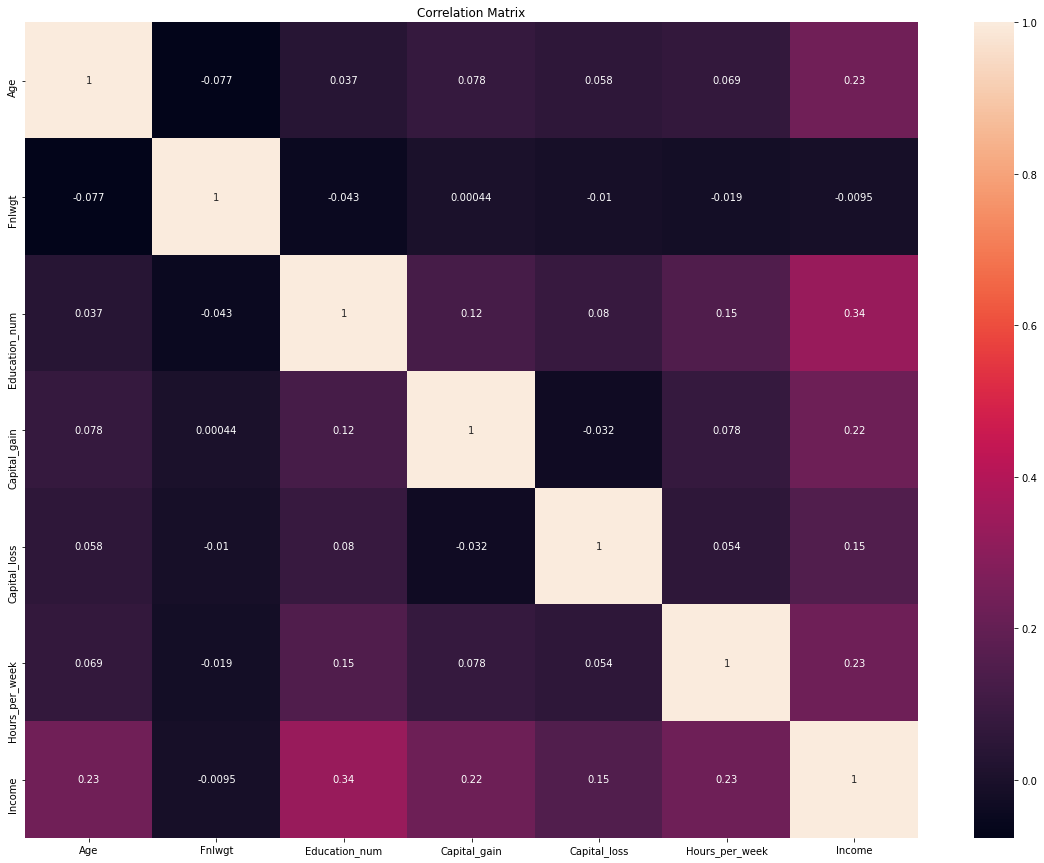

In [26]:
plt.figure(figsize = [20, 15])                             #multivariate analysis
sns.heatmap(df.corr(), annot = True)
plt.title('Correlation Matrix')
plt.show()

Education seems to be most correlated with Income (0.34), apart from that Age, Hours_per_week and Capital_gain are also very much correlated with Income at 0.23, 0.23 and 0.22 respectively.

Final Weight seems to be least correlated with Income at -0.01.

# Outliers and Skewness

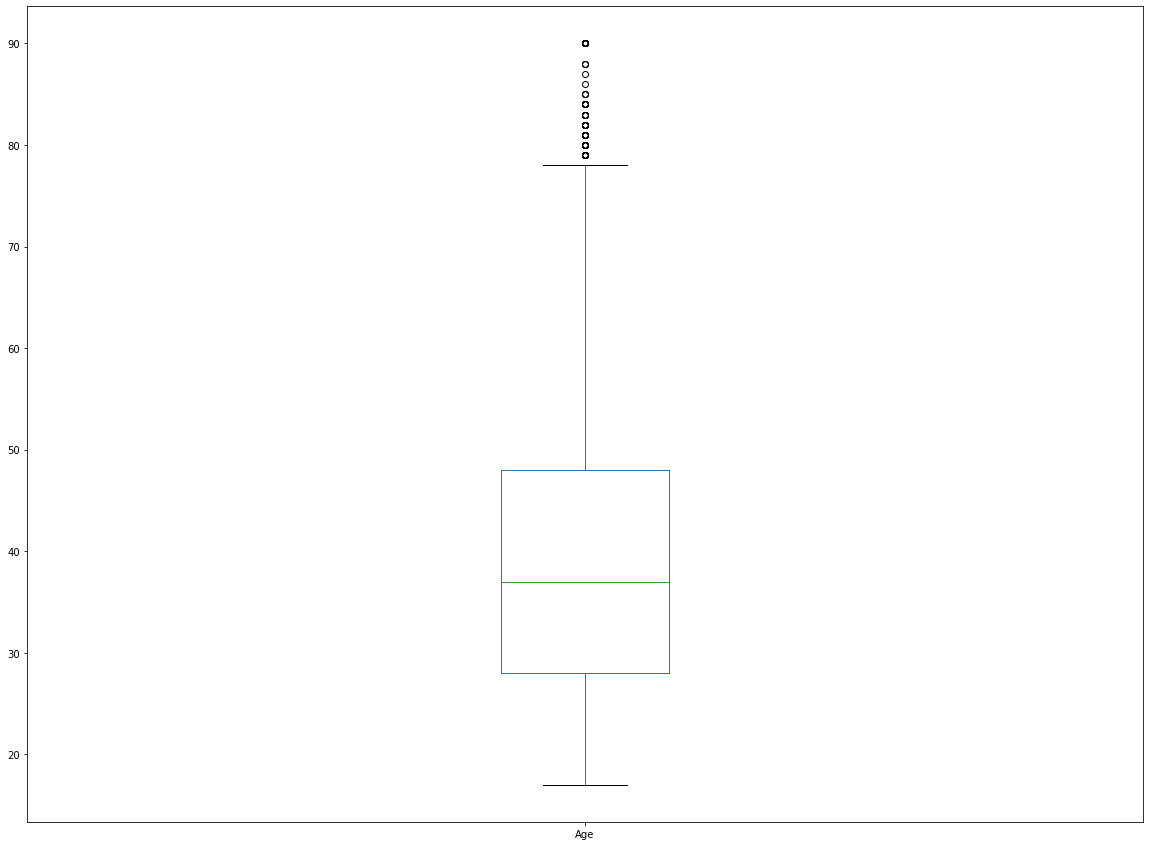

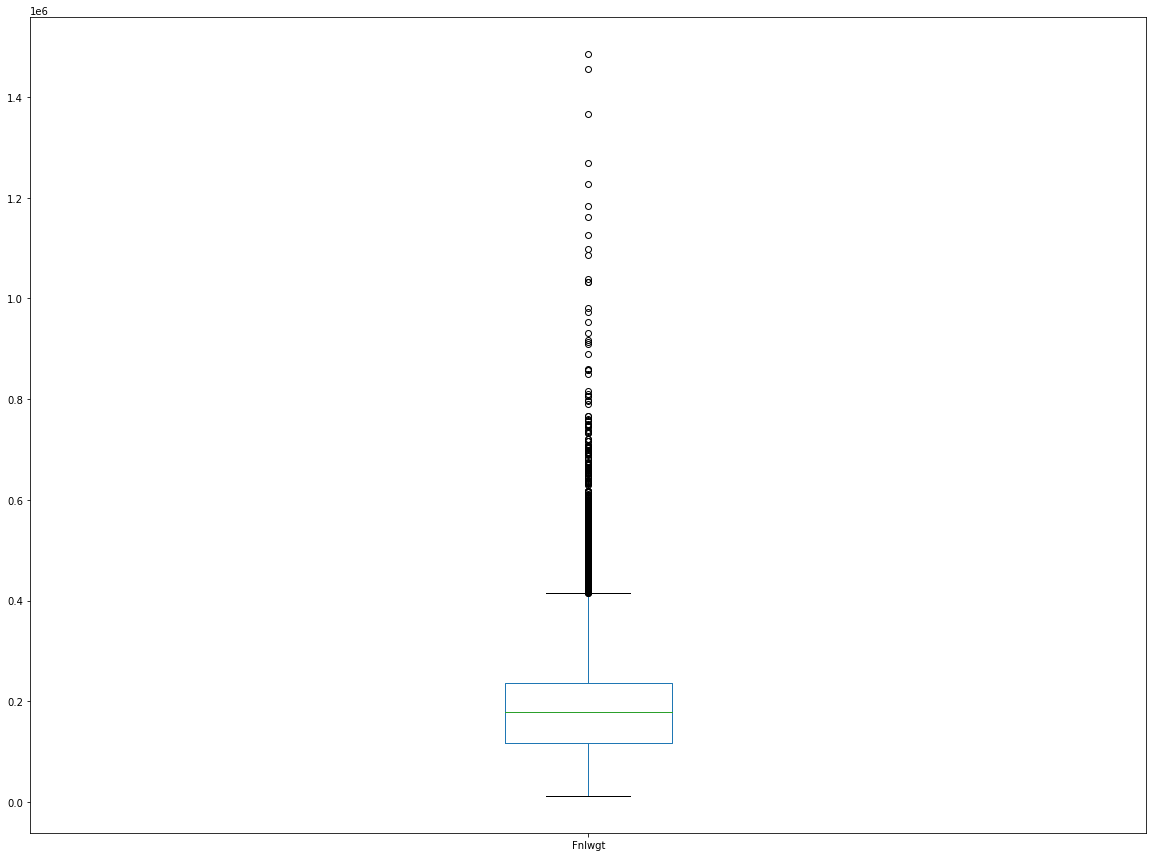

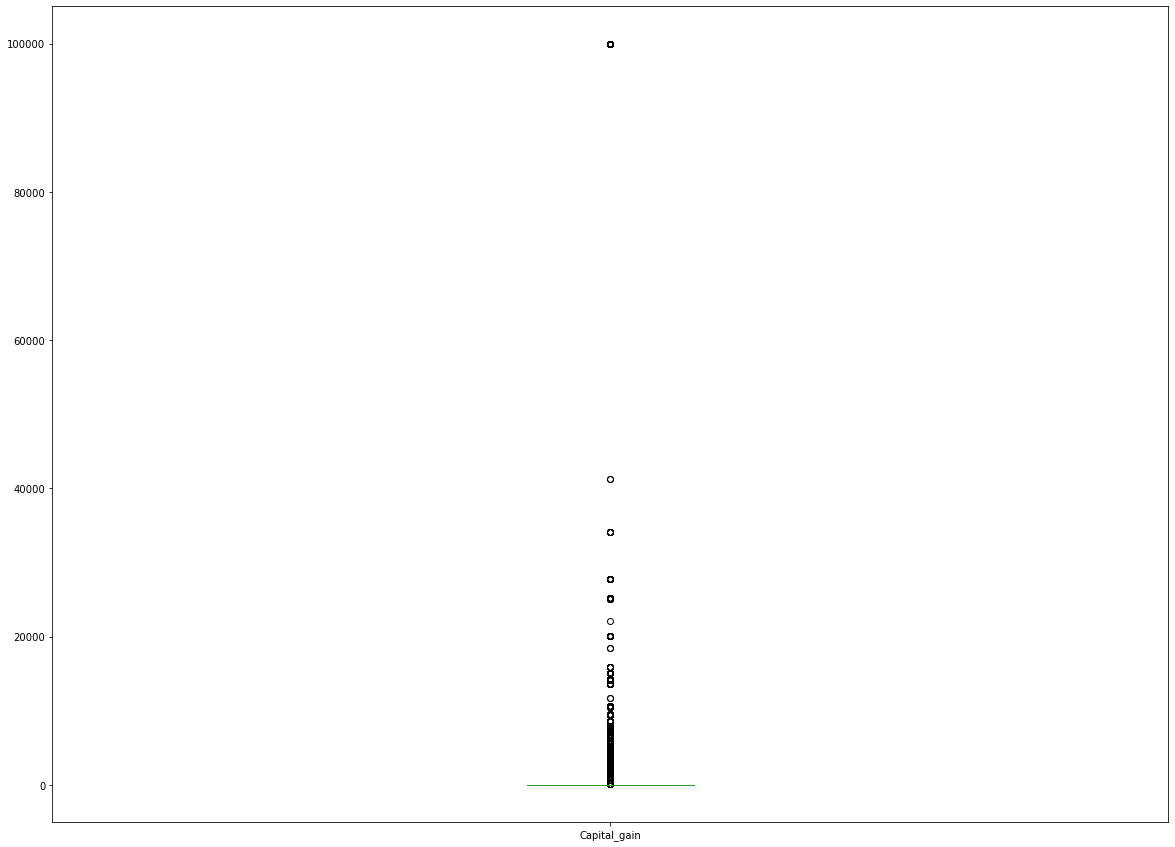

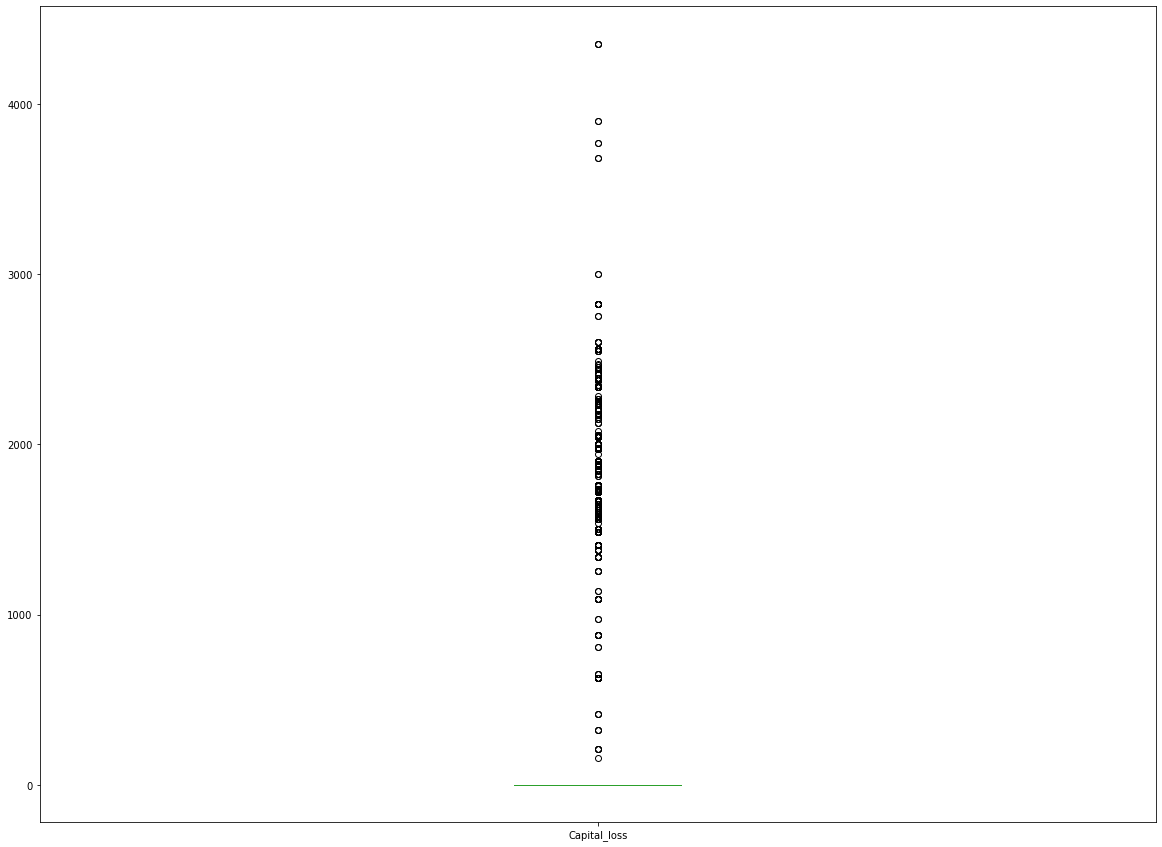

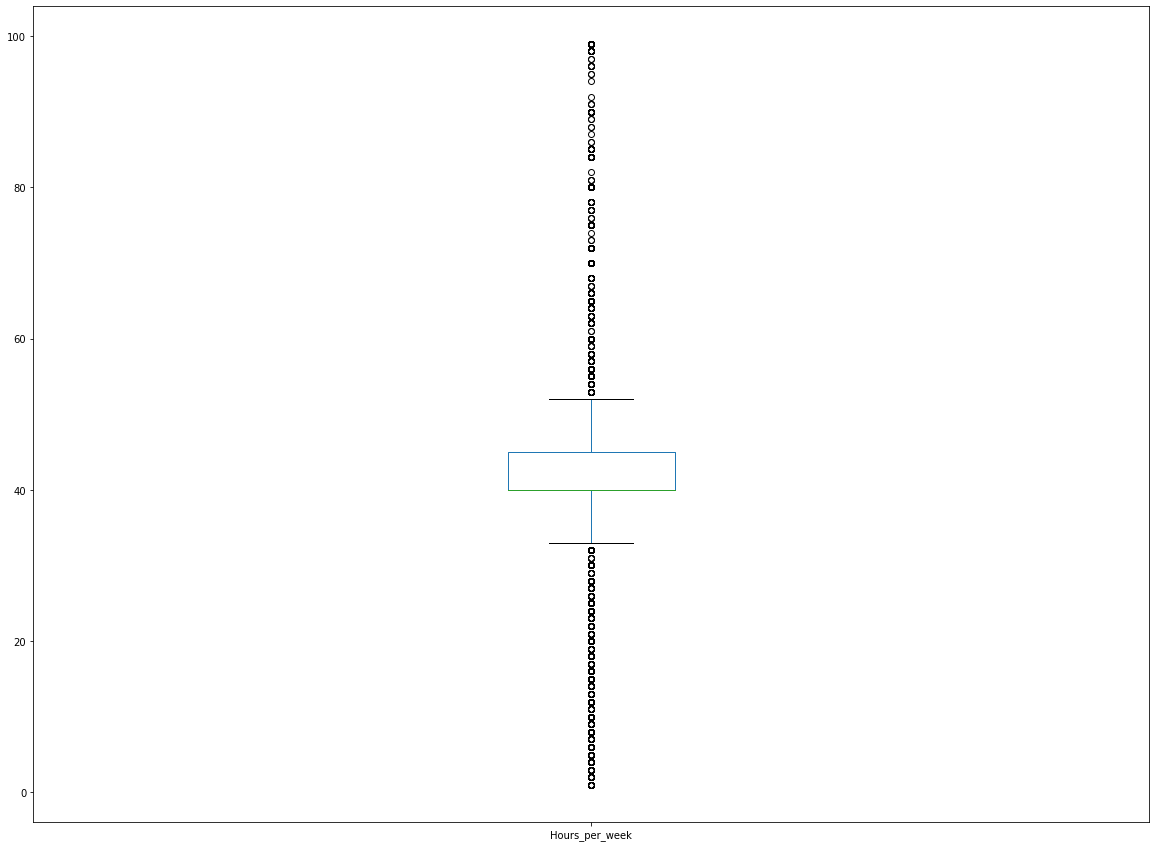

In [27]:
for i in cont_cols:
    plt.figure(figsize = (20, 15))
    df[i].plot.box()

In [28]:
df.skew()

Age                0.558738
Fnlwgt             1.446972
Education_num     -0.311630
Capital_gain      11.953690
Capital_loss       4.594549
Hours_per_week     0.227636
Income             1.212383
dtype: float64

In [29]:
cont_cols.remove('Age')
cont_cols.remove('Hours_per_week')

In [30]:
df_new = df

In [31]:
from sklearn.preprocessing import power_transform        #removing skewness
df_new[cont_cols] = power_transform(df[cont_cols], method='yeo-johnson')        #using yeo-johnson method due to presence of negative skewness
df_new = pd.DataFrame(df_new, columns = df.columns)

In [32]:
df_new.skew()

Age               0.558738
Fnlwgt            0.016914
Education_num    -0.311630
Capital_gain      3.016951
Capital_loss      4.299511
Hours_per_week    0.227636
Income            1.212383
dtype: float64

Skewness has been reduced significantly, even though it is still very high.

In [33]:
s = (df.dtypes == 'object')
obj_cols = list(s[s].index)

print("Categorical variables:")
print(obj_cols)

Categorical variables:
['Workclass', 'Education', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native_country']


In [34]:
obj_cols.remove('Education')

In [35]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for col in obj_cols:
    df_new[col] = label_encoder.fit_transform(df_new[col])

Label Encoded all the object columns, except for Education since we already have a column in the dataset for its encoded value.

In [36]:
df_new = df_new.drop('Education', axis = 1)

Dropping Education column since Education_num is already present in dataset.

In [37]:
x = df_new.drop('Income', axis = 1)
y = df_new['Income']

# Best Random State

In [38]:
maxAccu = 0
maxRS = 0

for i in range (1, 500):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = i)
    LR = LogisticRegression()
    LR.fit(x_train, y_train)
    pred = LR.predict(x_test)
    acc = accuracy_score(y_test, pred)
    if acc>maxAccu:
        maxAccu = acc
        maxRS = i
print ('Max Accuracy obtained is', maxAccu, 'on Random State', maxRS)

Max Accuracy obtained is 0.827088452088452 on Random State 448


# Creating Train Test Split

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 448)

In [40]:
LR = LogisticRegression()
nb = GaussianNB()
DTC = DecisionTreeClassifier()
svc = SVC()
rf = RandomForestClassifier()
models = [LR, nb, DTC, svc, rf]
for i in models:
    print (i)
    i.fit(x_train, y_train)
    pred = i.predict(x_test)
    print (accuracy_score(y_test, pred))
    print (confusion_matrix(y_test, pred))
    print (classification_report(y_test, pred))


LogisticRegression()
0.827088452088452
[[7008  506]
 [1183 1071]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      7514
           1       0.68      0.48      0.56      2254

    accuracy                           0.83      9768
   macro avg       0.77      0.70      0.73      9768
weighted avg       0.81      0.83      0.82      9768

GaussianNB()
0.8156224406224406
[[6655  859]
 [ 942 1312]]
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      7514
           1       0.60      0.58      0.59      2254

    accuracy                           0.82      9768
   macro avg       0.74      0.73      0.74      9768
weighted avg       0.81      0.82      0.81      9768

DecisionTreeClassifier()
0.8045659295659295
[[6484 1030]
 [ 879 1375]]
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      7514
           1       0.57      0.61      0.

In [41]:
for i in models:
    cvs = cross_val_score(i, x, y, cv = 5)
    print ('Cross Validation Score for ',i, ' model is :', cvs.mean())
    print (' ')

Cross Validation Score for  LogisticRegression()  model is : 0.8140970515970516
 
Cross Validation Score for  GaussianNB()  model is : 0.8102272727272728
 
Cross Validation Score for  DecisionTreeClassifier()  model is : 0.7999078624078624
 
Cross Validation Score for  SVC()  model is : 0.8196867321867322
 
Cross Validation Score for  RandomForestClassifier()  model is : 0.8527027027027028
 


All models have very low difference between accuracy score and cross val score, hence we will Random Forest Model since its accuracy is highest.

# Hypertuning

In [42]:
from sklearn.model_selection import GridSearchCV

In [43]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [44]:
rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 3)
rfc.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [45]:
rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 200}

In [46]:
rfc1=RandomForestClassifier(random_state=448, max_features='sqrt', n_estimators= 200, max_depth=8, criterion='entropy')
rfc1.fit(x_train, y_train)
predrfc1 = rfc1.predict(x_test)
print (accuracy_score(y_test, predrfc1))
print (confusion_matrix(y_test, predrfc1))
print (classification_report(y_test, predrfc1))

0.8604627354627354
[[7196  318]
 [1045 1209]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      7514
           1       0.79      0.54      0.64      2254

    accuracy                           0.86      9768
   macro avg       0.83      0.75      0.78      9768
weighted avg       0.85      0.86      0.85      9768



In [47]:
cvs = cross_val_score(rfc1, x, y, cv = 5)
print ('Cross Validation Score for ',rfc1, ' model is :', cvs.mean())

Cross Validation Score for  RandomForestClassifier(criterion='entropy', max_depth=8, max_features='sqrt',
                       n_estimators=200, random_state=448)  model is : 0.8513513513513512


There wasn't much improve in accuracy and cross validation score after gridsearchcv.

In [48]:
import pickle

filename = 'CensusIncomeRfc.pkl'
pickle.dump(rfc1, open(filename, 'wb'))

# Conclusion

In [49]:
loaded_model = pickle.load(open('CensusIncomeRfc.pkl', 'rb'))
result = loaded_model.score(x_test, y_test)
print (result)

0.8604627354627354


In [50]:
conclusion = pd.DataFrame([loaded_model.predict(x_test)[:], predrfc1[:]], index = ['Predicted', 'Original'])

In [51]:
conclusion

,0,1,2,3,4,5,6,7,8,9,...,9758,9759,9760,9761,9762,9763,9764,9765,9766,9767
Predicted,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
Original,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
